# SimpleHarmony Example
Example code for SimpleHarmony.

Must run on a Sage kernel.

In [1]:
import numpy as np
import tadasets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pandas import DataFrame, read_csv
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

## Load a point-cloud dataset

In [2]:
# Load example point cloud data

X = read_csv("exampleLemniscate.csv")
X = X[['x','y']]

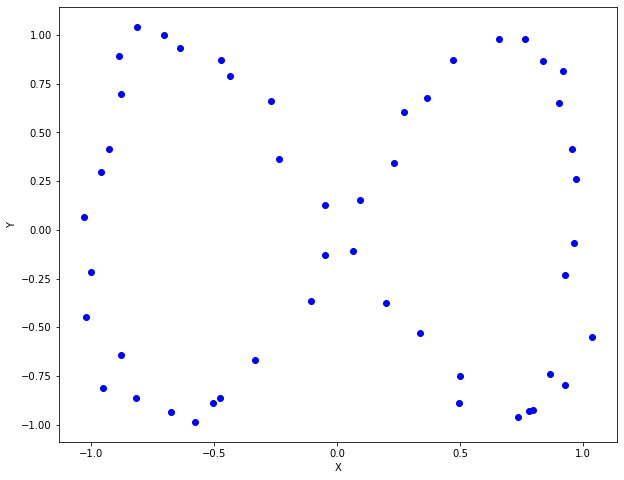

In [3]:
#Plot point cloud
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X['x'], X['y'], c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

## Build a Vietoris Rips complex on the dataset

We'll be picking our radius with the help of Ripser. We plot the barcode and pick a time value that seems to have some interesting homology.

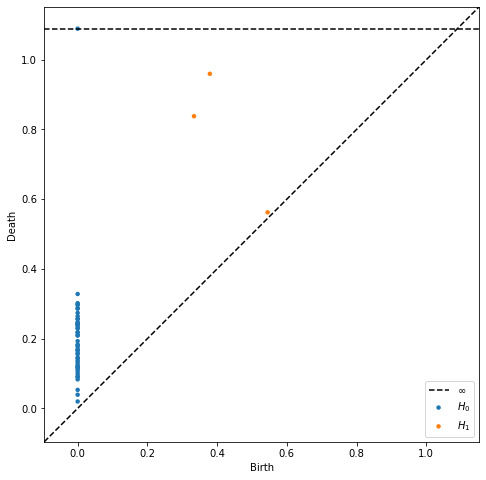

In [4]:
#Ripser for barcode
from ripser import ripser
from persim import plot_diagrams
ripserDict = ripser(X)
plot_diagrams(ripserDict['dgms'], show=True)

In [5]:
# What time looks like it has the most interesting homology, and in which degree?
timeLimit = 0.5
degree = 1

In [6]:
# Instantiate and build a rips filtration and the simplicial complex at time timeLimit.
# We will use cechmate to do this
import cechmate as cm
rips = cm.Rips(maxdim=degree)
ripsFiltration = rips.build(X.to_numpy())
sc = SimplicialComplex([sim for sim,time in ripsFiltration if time < timeLimit])
print(sc)

Simplicial complex with 50 vertices and 182 facets


## Pick a homology class

We'll do this by looking through cycles until we find one of interest.

In [7]:
# Let's pick a basis for the space of cycles and look for one that represents an interesting homology class.
import simpleHarmony.simpleHarmony as sh

cobd1 = sh.boundaryMatrix(sc, 1, cochain=True) #We ask for the transpose since Sage has backwards conventions for Matrix.kernel()
Z1 = cobd1.kernel()
cycleBasis = Z1.basis()

print(f"{len(cycleBasis)} cycles")
cobd1

97 cycles


146 x 50 sparse matrix over Rational Field (use the '.str()' method to see the entries)

Cycle 1


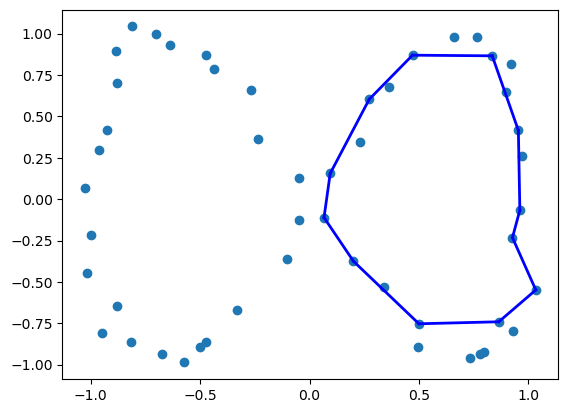

Cycle 41


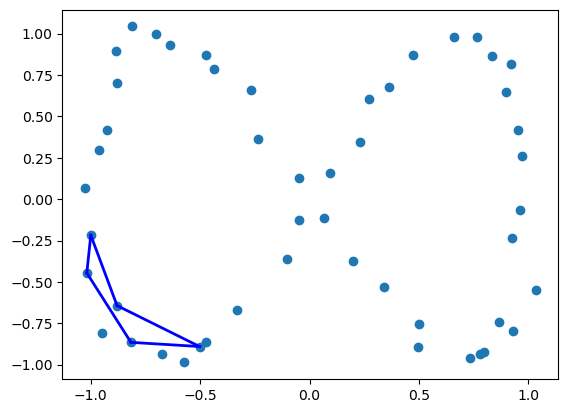

Cycle 81


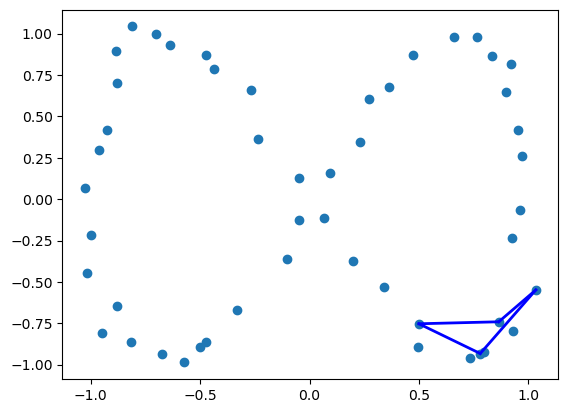

In [8]:
# Print out a few
for i in range(1,len(cycleBasis),40):
    cycle = cycleBasis[i]
    print("Cycle " + str(i))
    sh.plotCycle(X, cycle, sc._n_cells_sorted(1), threeD=False)

In [9]:
# Cycle 1 looks promising.
integralCycle = cycleBasis[1]

## Compute its $\mathbb Q$-harmonic representative
This is where we really start using SimpleHarmony.

In [10]:
# Compute rational harmonic representative
rho = sh.harmonicFormMatrix(sc, 1, ring=QQ, verbose = False)
rationalHarmonicCycle = rho * integralCycle

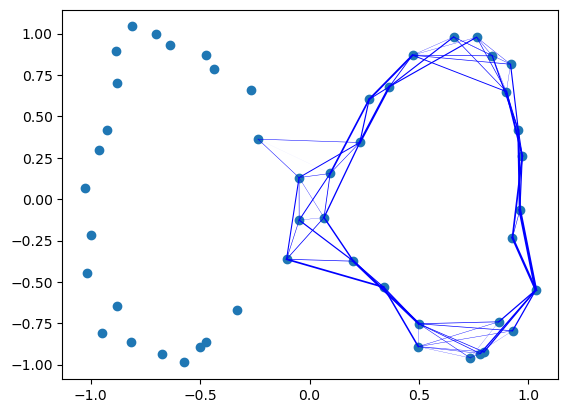

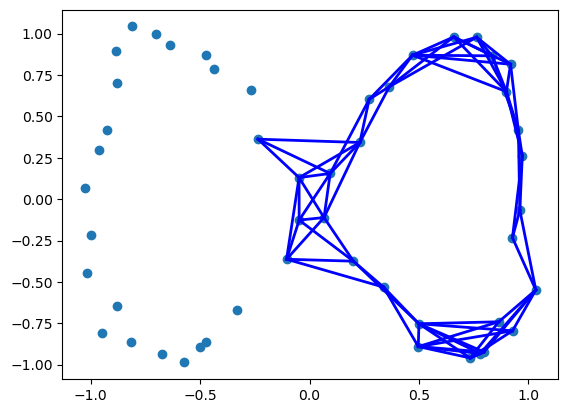

In [11]:
# Plot the cycle and its support

sh.plotCycle(X, rationalHarmonicCycle, sc._n_cells_sorted(1), threeD=False, plotSupportOnly=False)
sh.plotCycle(X, rationalHarmonicCycle, sc._n_cells_sorted(1), threeD=False, plotSupportOnly=True)

## Compute an $\mathbb{F}_p$-harmonic representative
We'll reduce our integral cycle mod $p$ to get an $\mathbb{F}_p$ cycle and compute its $\mathbb{F}_p$-harmonic representative.
This process is not guaranteed to work for any prime $p$, so we might need to look for a prime that works.

In [12]:
# Trying F2
try:
    rho_p = sh.harmonicFormMatrix(sc, 1, ring=GF(2), verbose = True)
except ZeroDivisionError:
    print("Error: map does not exist!")

Constructing chain complex
  starting dimension 2
    boundary matrix (cached): it's 146 by 180.
Extracting boundary module
Mapping to B complement.
Constructing Pseudoinverse
Error: map does not exist!


In [13]:
# Looks like the map doesn't exist over F2. Let's look for the smallest field over which it does exist.
for p in Primes():
    print("Trying F{}".format(p))
    try:
        rho_p = sh.harmonicFormMatrix(sc, 1, ring=GF(p), verbose = False)
    except ZeroDivisionError:
        continue
    break
field = GF(p)
print("Success")

Trying F2
Trying F3
Trying F5
Trying F7
Trying F11
Success


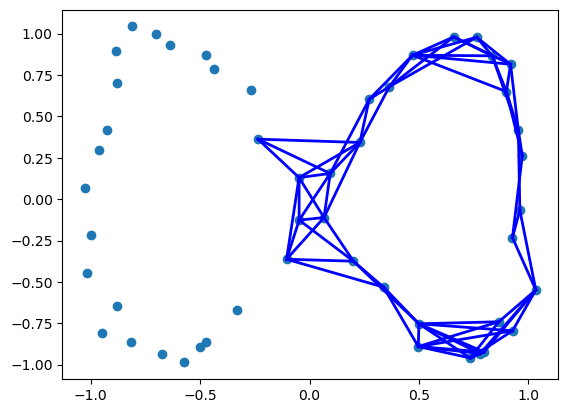

In [14]:
# Calculate the unique harmonic representative and try plotting its support.
fpCycle = integralCycle.apply_map(lambda x:field(x))
fpHarmonicCycle = rho_p*fpCycle
sh.plotCycle(X, fpHarmonicCycle, sc._n_cells_sorted(1), threeD=False, plotSupportOnly=True)